Rewritten NNDescent algorithm using matrices instead of dictionaries.

TODO: Remove for-loops where possible.

In [7]:
import torch
import time
import matplotlib.pyplot as plt
#from collections import defaultdict

class NNDescent:
  def __init__(self, data, k=2, trees=5, init=2, leaf_multiplier=1):
    # The data is a (N x d) matrix with N instances of d-dimensional points
    self.data = data
    N = data.shape[0]
    self.k = k
    self.numtrees = trees
    
    # A 2D tensor representing a directed graph.
    # The value a = graph[i,j] represents an edge from point x_i to x_a.
    self.graph = torch.zeros(size=[N, k], dtype=torch.long)
    
    # Initialize graph randomly or with forest
    if init == 1:
      self.initialize_graph_randomly()
    elif init == 2:
      self.initialize_graph_big_random(data)
    elif init == 3:
      self.leaves = self.initialize_graph_forest(data, leaf_multiplier)
    
#     accuracy, _ = init_accuracy(data,self.graph,torch.zeros([N, k]))
#     print('Initial Accuracy: ',accuracy)
    
    # A set of tuples (i,j) of indices for which the distance has already been calculated.
    self.explored_edges = set()

    # A 2D tensor representing the distance between point x_i and x_graph[i,j]
    self.k_distances = torch.zeros([N, k])
#     self.calculate_all_distances()
    

  def initialize_graph_randomly(self):
    '''
    Initializes self.graph with random values such that each point has k distinct neighbors
    '''
    N, k = self.graph.shape
    # Initialize graph randomly, removing self-loops
    self.graph = torch.randint(high = N-1, size=[N,k], dtype=torch.long)
    row_indices = torch.arange(N).unsqueeze(1).repeat(1,k)
    self.graph[self.graph>=row_indices] += 1

  def initialize_graph_big_random(self, data):
    '''
    Initializes self.graph randomly, but with more neighbours at the start
    '''
    N, k = self.graph.shape
    temp_graph = torch.tensor([])
        
    # make 'trees', combine into giant graph with each element (row) having k * num_trees neighbours
    # this is a small for loop - numtrees and k << datapoints
    for j in range(self.numtrees):
      tree_graph = torch.tensor([])
      for i in range(k):
        tree_graph = torch.cat((tree_graph,torch.randperm(N)),0) # generate randomly shuffled list of N indices
      tree_graph = tree_graph.reshape(-1,k) # creates a N x k tensor with N indices, each appearing k times. This represents 1 'tree'
      temp_graph = torch.cat((temp_graph,tree_graph),1) # combine into giant N x (k*num_trees) tensor. This represents the forest
    
    # find KNN for each row in giant graph
    # TODO - implement the below without a for loop
    for i, row in enumerate(temp_graph):
      temp_row = torch.unique(row).type(torch.LongTensor) # remove duplicates
      temp_row = temp_row[temp_row != i] # remove self
      
      temp_points = data[temp_row,:] # pick out elements from dataset
      distances = dist_bulk(temp_points,data[i]) # Euclidean distances
      indices = distances.topk(k=self.k, largest=False).indices # find indices of KNN
      self.graph[i] = temp_row[indices] # assign KNN to graph
      
  def initialize_graph_forest(self, data, leaf_multiplier):
    '''
    Initializes self.graph with a forest of random trees, such that each point has k distinct neighbors
    '''
    N, k = self.graph.shape
    dim = data.shape[1]
    
    temp_graph = torch.tensor(())
    for j in range(self.numtrees):
      # Create trees, obtain leaves
      t = tree(data, k = k*leaf_multiplier)
      
      # Create temporary graph, 1 for each tree
      # Leaves are of uneven size; select smallest leaf size as graph size
      cols = min([len(leaf) for leaf in t.leaves])
      rows = len(t.leaves)
      tree_graph = torch.zeros((N, cols))
      leaves = torch.tensor(())
      idx_update = torch.tensor(())
      
      # Update graph using leaves
      for leaf in t.leaves:
        temp_idx = torch.as_strided(torch.tensor(leaf).repeat(1,2),size=[len(leaf),cols],stride=[1,1],storage_offset=1)
        tree_graph[leaf,:] = temp_idx.float() # update graph. a lot of overwriting
#         idx_update = torch.cat((idx_update,temp_idx), 0)
#         leaves = torch.cat((leaves,torch.tensor(leaf)), 0)
#       leaves = leaves.unique().long()
#       tree_graph[leaves,:] = idx_update.float()
      # Concatenate all graphs from all trees into 1 giant graph
      temp_graph = torch.cat((temp_graph,tree_graph), 1)
    
    warning_count = 0 # number of indices for which some neighbours are random
    # find KNN for each row in giant graph
    # TODO - implement the below without a for loop
    for i, row in enumerate(temp_graph):
      temp_row = torch.unique(row).type(torch.LongTensor) # remove duplicates
      temp_row = temp_row[temp_row != i] # remove self
      
      temp_points = data[temp_row,:] # pick out elements from dataset
      d=((data[i].reshape(1,dim).unsqueeze(1)-temp_points.unsqueeze(0))**2).sum(-1)
      distances, indices = torch.sort(d,dim=1)
      indices = indices.flatten()[:k]
      
      indices = temp_row[indices]
      
      # pad with random indices if there are not enough neighbours
      warning = False # warning flag
      while len(indices) < k:
        pad = torch.randint(high = N-1, size=[k-len(indices),], dtype=torch.long)
        indices = torch.cat((indices,pad))
        indices = torch.unique(indices).type(torch.LongTensor) # remove duplicates
        indices = indices[indices != i] # remove self
        warning = True

      self.graph[i] = indices # assign KNN to graph
      
      if warning:
        warning_count += 1
    
    if warning_count:
      print("WARNING!",warning_count," INDICES ARE RANDOM!")
        
  def calculate_all_distances(self):
    '''
    Updates the distances (self.k_distances) of the edges found in self.graph.
    '''
    # Note: Start with for loop for simplicity. TODO: Try to remove loop.
    for i, row in enumerate(self.graph):
      # Indices of current k neighbors in self.graph
      neighbor_indices = [(i,int(r)) for r in row]

      # The distances of those neighbors are saved in k_distances
      self.k_distances[i] = torch.Tensor([dist(self.data[a],self.data[b]) for a,b in neighbor_indices])

      # Add pairs to explored_edges set
      self.explored_edges.update(neighbor_indices) 
    

  def update_graph(self, iter=5):
    '''
      Updates the graph using algorithm: https://pynndescent.readthedocs.io/en/latest/how_pynndescent_works.html
    '''
    # [STEP 1: Start with random graph.] Iterate
    start = time.time()
    for it in range(iter):
#       print("Iteration number",it,"with average distance of",torch.mean(self.k_distances).item(),"Took", time.time()-start,"seconds.")
      has_changed = False

      # [STEP 2: For each node:] (TODO: Investigate whether this can be vectorized.)
      for i, neighbors in enumerate(self.graph):
        # Distances of current neighbors
        dist_current_neighbors = self.k_distances[i]

        # [STEP 3: Measure distance from the node to the neighbors of its neighbors]
        # Find neighbors of neighbors
        potential_neighbors = {a.item() for a in self.graph[neighbors].flatten() \
                               if a not in neighbors and a!=i and (i,int(a)) not in self.explored_edges}
        potential_distances = torch.Tensor([dist(self.data[i],self.data[n]) for n in potential_neighbors])
        self.explored_edges.update([(i,int(r)) for r in potential_neighbors])

        # Concatenate potential neighbors to list of neighbors (indices and distances)
        cat_idx = torch.cat([neighbors, torch.Tensor(list(potential_neighbors))])
        cat_dist = torch.cat([self.k_distances[i], potential_distances])

        # [STEP 4: If any are closer, then update the graph accordingly, and only keep the k closest]
        # Sort using torch.sort(), which also returns sorted indices
        dist_sorted, idx = torch.sort(cat_dist)
        if torch.max(idx[:self.k]) >= self.k:
          has_changed = True
          self.graph[i] = cat_idx[idx[:self.k]]
          self.k_distances[i] = dist_sorted[:self.k]
        
      # [STEP 5: If any changes were made, repeat iteration, otherwise stop]
#       if not has_changed:
#         print("Nothing changed in iteration",it)
#         break
#     print("Done.")

  def k_nearest_graph_search(self,x):
    '''
    Gets the k nearest neighbors of input x according to the graph, using this algorithm:
      https://pynndescent.readthedocs.io/en/latest/how_pynndescent_works.html#Searching-using-a-nearest-neighbor-graph
    Input: 
      x - a torch tensor of shape (1,d), where d is the number of dimentions of the input data.
      TODO: Add support for batches, so x can be of shape (n, d). Not sure how to batch-ify the graph search...
    Output:
      The indices of the k nearest neighbors according using graph search with random initialization.
    '''

    # Random initialization for starting point of search
    random_start = torch.randint(len(self.data),size=[1], dtype=torch.long)
    # A list of random initialization and its neighbors
    candidate_idx = torch.cat([self.graph[random_start].squeeze(),random_start], dim=0) 
    # Track the nodes we have explored already
    explored = [random_start]
    
    count = 0
    while True:
      count += 1
      # [2. Look at nodes connected by an edge to the best untried node in graph]
      unexplored = [i for i in candidate_idx if i not in explored]
      if not unexplored:
        # if nothing is unexplored, the search is over
        break 
    
      # Add neighbors of the first unexplored point to the list of candidates
      candidate_idx = torch.cat([self.graph[unexplored[0]],candidate_idx], dim=0) 
      # and mark it as explored
      explored = explored + [unexplored[0]]
    
      # [4. Sort by closeness]
      distances = ((self.data[candidate_idx].unsqueeze(1) - x.unsqueeze(0))**2).sum(-1).squeeze() 
      sorted, idx = torch.sort(distances,dim=0)
      candidate_idx = candidate_idx[idx]
    
      # [5. Truncate to k best]
      # TODO: use Hudson's unwanted_indices method from "Loop replacement.ipynb" to get unique values.
      # It might be faster and is probably more useful when algo supports predictions for batches.
      candidate_idx = torch.unique_consecutive(candidate_idx)[:k] # unique_consecutive doesn't sort
    
      # [6. Return to step 2. If we have already tried all candidates in pool, we stop in the if not unexplored]
    
    # Return the k candidates
#     print("Graph search finished after",count,"steps")
    return candidate_idx

  def predict(self,x):
    '''
    Predict output using tree. Hasn't been implemented yet. Needs labels y.
    '''
    pass
    
def dist(x,y):
  # Square of euclidian distance. Skip the root for faster computation.
  return torch.sum((x-y)**2)

def dist_bulk(x,y):
  # Square of euclidian distance. Skip the root for faster computation.
  # For datasets
  return ((x-y)**2).sum(-1)

class tree:
  '''
  Random projection tree class that splits the data evenly per split
  Each split is performed by calculating the projection distance of each datapoint to a random unit vector
  The datapoints are then split by the median of of these projection distances
  The indices of the datapoints are stored in tree.leaves, as a nested list
  '''
  def __init__(self, x, k=5):
    self.min_size = 2*k-1
    self.leaves = []
    self.sizes = []
    self.big_leaves = [] # leaves at depth = 5
    indices = torch.arange(x.shape[0])
    self.tree = self.make_tree(x, indices, depth = 0)

  def make_tree(self, x, indices, depth):
    if depth == 5: # add to big_leaves if depth=5
      self.big_leaves.append(int(indices[0]))
    if x.shape[0] > self.min_size:
      v = self.choose_rule(x)
      distances = torch.tensordot(x,v,dims=1) # create list of projection distances
      median = torch.median(distances)
      left_bool = distances <= median # create boolean array where entries are true if distance <= median
      right_bool = ~left_bool # inverse of left_bool
      left_indices = indices[left_bool]
      right_indices = indices[right_bool]
      self.make_tree(x[left_bool,:],left_indices, depth+1)
      self.make_tree(x[right_bool,:],right_indices, depth+1)
    elif x.shape[0] != 0:
      self.leaves.append(indices.tolist())
      self.sizes.append(x.shape[0])
    return

  def choose_rule(self, x):
    dim = x.shape[1]
    v = torch.rand(dim) # create random vector
    v /= torch.norm(v) # normalize to unit vector
    return v
    
def init_accuracy(data, graph, k_distances):
  '''
  Takes in data and graph to check accuracy of graph's assigned k nearest neighbours
  Uses torch brute force to find actual k nearest neighbours
  Returns accuracy: proportion of correct nearest neighbours
  Also returns distance error: (average_distance-true_distances)/true_distance (of k nearest neighbours)
  '''
  N, k = graph.shape

  # Calculate true distances, indices
  d=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
  true_distances, true_indices = torch.sort(d,dim=1)

  # get k nearest neighbours
  true_indices = true_indices[:,:k]
  true_distances = true_distances[:,:k]
  
  # Calculate number of correct nearest neighbours
  accuracy = 0
  for i in range(k):
    accuracy += torch.sum(graph == true_indices).float()
    true_indices = torch.roll(true_indices, 1, -1) # Create a rolling window (index positions may not match)
  accuracy = float(accuracy/(N*k)) # percentage accuracy

  # Calculate accuracy of distances
  true_average = torch.mean(true_distances)
  graph_average = torch.mean(k_distances)
  distance_error = float((graph_average-true_average)/true_average)

  return accuracy, distance_error

# def give_KNN(data,k):
#   '''
#   Takes in data and graph to check accuracy of graph's assigned k nearest neighbours
#   Uses torch brute force to find actual k nearest neighbours
#   Returns accuracy: proportion of correct nearest neighbours
#   Also returns distance error: (average_distance-true_distances)/true_distance (of k nearest neighbours)
#   '''
#   # Calculate true distances, indices
#   d=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
#   true_distances, true_indices = torch.sort(d,dim=1)

#   # get k nearest neighbours
#   true_indices = true_indices[:,1:k+1]
#   true_distances = true_distances[:,1:k+1]
  
#   return true_distances, true_indices

# def check_accuracy2(data, graph, k_distances):
#   '''
#   Takes in data and graph to check accuracy of graph's assigned k nearest neighbours
#   Uses torch brute force to find actual k nearest neighbours
#   Returns accuracy: proportion of correct nearest neighbours
#   Also returns distance error: (average_distance-true_distances)/true_distance (of k nearest neighbours)
#   '''
#   N, k = graph.shape
#   graph = torch.sort(graph,dim=1)[0] # sort each row of graph

#   # Calculate true distances, indices
#   d=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
#   true_distances, true_indices = torch.sort(d,dim=1)
  
#   # get k nearest neighbours
#   true_indices = true_indices[:,1:k+1].sort(dim=1)[0]
#   true_distances = true_distances[:,1:k+1].sort(dim=1)[0]
  
#   counter = 0
#   # Calculate number of correct nearest neighbours
#   for i, row in enumerate(true_indices):
#     if not torch.all(torch.eq(row,graph[i])):
#       counter += 1
#       print(row,true_distances[i])
#       print(graph[i],distances[i])
#   accuracy = (N - counter) / N
      
#   # Calculate accuracy of distances
#   true_average = torch.mean(true_distances)
#   graph_average = torch.mean(k_distances)
#   distance_error = float((graph_average-true_average)/true_average)

#   return accuracy, distance_error

In [ ]:
data = torch.randn(size=[1000,4])
k = 5
n = NNDescent(data, k=k, init=3)
print(init_accuracy(data, n.graph, n.k_distances))
t=tree(data)
print(t.big_leaves)

In [8]:
# Testing out NNDescent class
# torch.manual_seed(1)
data = torch.Tensor([[1.0,1.0], [2.0,1.0], [3.0,1.0], [4.0,1.0],
                     [1.0,2.0], [2.0,2.0], [3.0,2.0], [4.0,2.0]])  
data = torch.randn(size=[1000,4])
# print(data)  

torch.set_printoptions(threshold=10)

k = 5

# Initialize NNDescent graph randomly

print("Initializing RANDOMLY...")
start = time.time()
n = NNDescent(data, k=k, init=1)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
# print("Distances:")
print(torch.sqrt(n.k_distances))

print("Updating...\n")
start = time.time()
n.update_graph(iter=25)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
print("Distances:")
print(torch.sqrt(n.k_distances))
#print(n.k_distances)
accuracy, distance_error = check_accuracy(data, n.graph, n.k_distances)
print("Accuracy: ",accuracy)
print("Distance Error: ",distance_error,'\n')



# Initialize NNDescent graph with big random
print("Initializing BIG RANDOM...")
start = time.time()
n = NNDescent(data, k=k, init=2)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
print("Distances:")
print(torch.sqrt(n.k_distances))

print("Updating...\n")
start = time.time()
n.update_graph(iter=25)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
print("Distances:")
print(torch.sqrt(n.k_distances))
#print(n.k_distances)
accuracy, distance_error = check_accuracy(data, n.graph, n.k_distances)
print("Accuracy: ",accuracy)
print("Distance Error: ",distance_error,'\n')



# Initialize NNDescent graph with forest
print("Initializing FOREST...")
start = time.time()
n = NNDescent(data, k=k, init=3)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
print("Distances:")
print(torch.sqrt(n.k_distances))

print("Updating...\n")
start = time.time()
n.update_graph(iter=25)
print("Took", time.time()-start,"seconds.\n")
print("Graph:")
print(n.graph)
print("Distances:")
print(torch.sqrt(n.k_distances))
#print(n.k_distances)
accuracy, distance_error = check_accuracy(data, n.graph, n.k_distances)
print("Accuracy: ",accuracy)
print("Distance Error: ",distance_error,'\n')



# Brute force search
print("BRUTE FORCE")
start = time.time()
m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
distances, brute_force = torch.sort(m,dim=1)
brute_force = brute_force[:,1:k+1]
distances = distances[:,1:k+1]
  
print("Took", time.time()-start,"seconds.\n")
print(brute_force)
print('mean distance',(distances).sqrt().mean())
accuracy, distance_error = check_accuracy(data, brute_force, distances)
print("Accuracy: ",accuracy)
print("Distance Error: ",distance_error,'\n')

# Get k nearest neighbors using graph search
print()
print("Graph search")
#x = torch.Tensor([4, 0]).unsqueeze(0) # size 1 x d
x = torch.randn(size=[1,data.shape[1]])
print("x is",x)
start = time.time()
k_nearest = n.k_nearest_graph_search(x)
print("Took", time.time()-start,"seconds.")
print("Nearest indices with graph search:",k_nearest)
print("coordinates of nearest dots:",n.data[k_nearest])

# Get k nearest using brute force knn
print("\nActual nearest using KNN")
start = time.time()
m=((data.unsqueeze(1)-x.unsqueeze(0))**2).sum(-1).squeeze() # Infinity is added to diagonal
print(m)
brute_force = torch.sort(m,dim=0)[1][:k]
print("Took", time.time()-start,"seconds.")
print("The KNN nearest are:",brute_force)
print("coordinates of nearest dots:",n.data[brute_force])

Initializing RANDOMLY...
Took 0.01110386848449707 seconds.

Graph:
tensor([[593, 716,  65, 537,  65],
        [583,  78, 821, 379, 916],
        [731,  10, 410, 617, 369],
        ...,
        [711, 618, 161, 117,  87],
        [731, 490, 176, 142, 320],
        [157,  58, 516, 493, 898]])


AttributeError: 'NNDescent' object has no attribute 'k_distances'

WARNING! 2  INDICES ARE RANDOM!


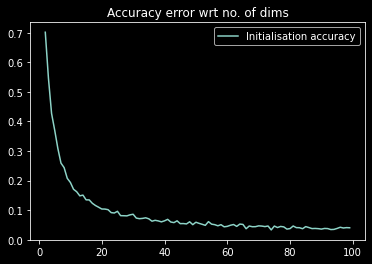

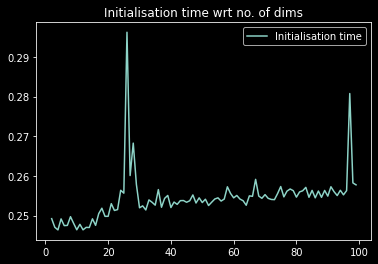

In [97]:
# Check forest initialization accuracy wrt dim
timings = []
accuracies = []
dims = list(range(2,100))
N = 1000
k = 4
for dim in dims:
  data = torch.randn(size=[N,dim])
  start = time.time()
  n = NNDescent(data, k=k, init=3)
  timings.append(time.time()-start)
  accuracy, _ = check_accuracy(data, n.graph, torch.zeros([N, k]))
  accuracies.append(accuracy)

plt.plot(dims,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy error wrt no. of dims')
plt.show()
plt.plot(dims,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt no. of dims')
plt.show()

WARNING! 3  INDICES ARE RANDOM!
WARNING! 2  INDICES ARE RANDOM!
WARNING! 2  INDICES ARE RANDOM!
WARNING! 3  INDICES ARE RANDOM!
WARNING! 3  INDICES ARE RANDOM!
WARNING! 6  INDICES ARE RANDOM!
WARNING! 13  INDICES ARE RANDOM!
WARNING! 1  INDICES ARE RANDOM!
WARNING! 11  INDICES ARE RANDOM!
WARNING! 14  INDICES ARE RANDOM!
WARNING! 10  INDICES ARE RANDOM!
WARNING! 6  INDICES ARE RANDOM!
WARNING! 12  INDICES ARE RANDOM!
WARNING! 31  INDICES ARE RANDOM!


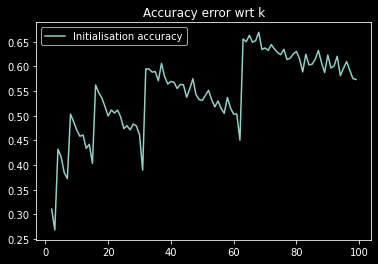

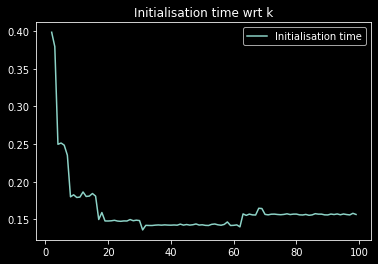

In [98]:
# Check forest initialization accuracy wrt k
timings = []
accuracies = []
dim = 4
k_s = list(range(2,100))
N = 1000
for k in k_s:
  data = torch.randn(size=[N,dim])
  start = time.time()
  n = NNDescent(data, k=k, init=3)
  timings.append(time.time()-start)
  accuracy, _ = check_accuracy(data, n.graph, torch.zeros([N, k]))
  accuracies.append(accuracy)

plt.plot(dims,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy wrt k')
plt.show()
plt.plot(dims,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt k')
plt.show()

WARNING! 1000  INDICES ARE RANDOM!
WARNING! 2  INDICES ARE RANDOM!


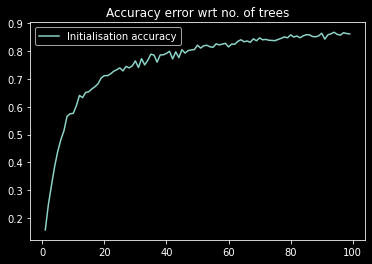

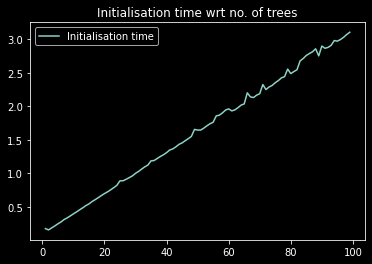

In [99]:
# Check initialisation accuracy wrt no. of trees
timings = []
accuracies = []
dim = 4
k = 4
N = 1000
tree_list = list(range(1,100))
for trees in tree_list:
  data = torch.randn(size=[N,dim])
  start = time.time()
  n = NNDescent(data, k=k, init=3, trees=trees)
  timings.append(time.time()-start)
  accuracy, _ = check_accuracy(data, n.graph, torch.zeros([N, k]))
  accuracies.append(accuracy)

plt.plot(tree_list,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy wrt no. of trees')
plt.show()
plt.plot(tree_list,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt no. of trees')
plt.show()

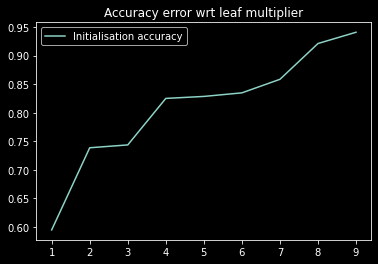

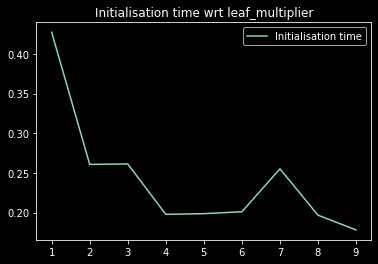

In [100]:
# Check initialisation accuracy wrt size of leaf
timings = []
accuracies = []
dim = 4
k = 4
N = 1000
trees = 10
leaf_multiplier = list(range(1,10))
for leaf_mul in leaf_multiplier:
  data = torch.randn(size=[N,dim])
  start = time.time()
  n = NNDescent(data, k=k, init=3, trees=trees, leaf_multiplier = leaf_mul)
  timings.append(time.time()-start)
  accuracy, _ = check_accuracy(data, n.graph, torch.zeros([N, k]))
  accuracies.append(accuracy)

plt.plot(leaf_multiplier,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy wrt leaf multiplier')
plt.show()
plt.plot(leaf_multiplier,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt leaf_multiplier')
plt.show()

In [3]:
# Check initialisation accuracy wrt no. of datapoints
timings = []
accuracies = []
dim = 4
k = 4
trees = 10
leaf_multiplier = 1
N_s = list(range(1000,25000,1000))
with torch.no_grad():
  for N in N_s:
    print(N)
    data = torch.randn(size=[N,dim])
    start = time.time()
    n = NNDescent(data, k=k, init=3, trees=trees, leaf_multiplier = leaf_multiplier)
    timings.append(time.time()-start)
    accuracy, _ = check_accuracy(data, n.graph, torch.zeros([N, k]))
    accuracies.append(accuracy)

plt.plot(N_s,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy wrt no. of datapoints')
plt.show()
plt.plot(N_s,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt no. of datapoints')
plt.show()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


NameError: name 'plt' is not defined

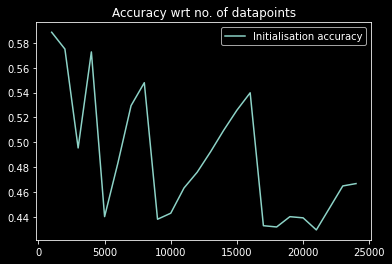

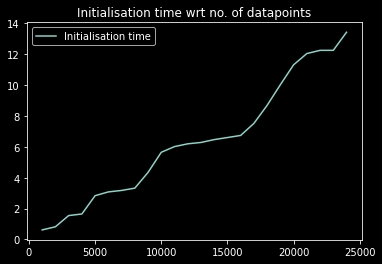

In [6]:
plt.plot(N_s,accuracies,label = 'Initialisation accuracy')
plt.legend()
plt.title('Accuracy wrt no. of datapoints')
plt.show()
plt.plot(N_s,timings,label = 'Initialisation time')
plt.legend()
plt.title('Initialisation time wrt no. of datapoints')
plt.show()

In [120]:
# Sandbox for testing
i = 0
neighbors = n.graph[i]
print("Neighbors:",neighbors)
print("Neighbors of neighbors:",n.graph[neighbors].flatten())
potential_neighbors = {a.item() for a in n.graph[neighbors].flatten() if a not in neighbors and a!=i}
print("New potential neighbors:", potential_neighbors)
potential_distances = torch.Tensor([dist(data[i],data[n]) for n in potential_neighbors])
print("Potential distances:", (potential_distances))
cat_idx = torch.cat([neighbors, torch.Tensor(list(potential_neighbors))])
cat_dist = torch.cat([n.k_distances[i], potential_distances])
print("cat_idx:", cat_idx)
print("cat_dist:", cat_dist)
print("sort cat:", torch.sort(cat_dist))
val, idx = torch.sort(cat_dist)
print("idx max", torch.max(idx)>3)
print()
print("New neighbors:",cat_idx[idx[:3]])
print("New distances:",val[:3])

Neighbors: tensor([27, 37])
Neighbors of neighbors: tensor([ 0, 37, 46,  0])
New potential neighbors: {46}
Potential distances: tensor([1.6462])
cat_idx: tensor([27., 37., 46.])
cat_dist: tensor([0.6104, 1.0715, 1.6462])
sort cat: torch.return_types.sort(
values=tensor([0.6104, 1.0715, 1.6462]),
indices=tensor([0, 1, 2]))
idx max tensor(False)

New neighbors: tensor([27., 37., 46.])
New distances: tensor([0.6104, 1.0715, 1.6462])


In [6]:
import torch
torch.set_printoptions(threshold=10)
a = torch.randint(high = 100, size = (100,4))
b = a
b = b.roll(1,1)
print(a)
print(b)
accuracy = torch.zeros((1,))
for i in range(4):
  accuracy += torch.sum(a == b).float()
  b = torch.roll(b, 1, -1) # Create a rolling window (index positions may not match)
  print(accuracy)
accuracy = float(accuracy/(1000*4)) # percentage accuracy
print(accuracy)

tensor([[33, 57, 13, 49],
        [98, 93, 50, 69],
        [26, 84, 96,  1],
        ...,
        [15,  8, 13, 87],
        [15, 75, 52, 98],
        [74, 70, 74, 90]])
tensor([[49, 33, 57, 13],
        [69, 98, 93, 50],
        [ 1, 26, 84, 96],
        ...,
        [87, 15,  8, 13],
        [98, 15, 75, 52],
        [90, 74, 70, 74]])
tensor([2.])
tensor([6.])
tensor([8.])
tensor([408.])
0.10199999809265137


1000
2000


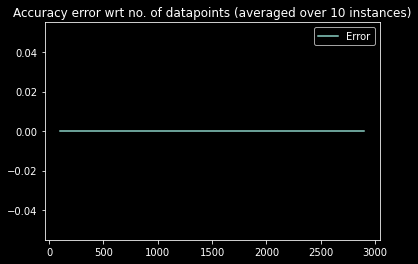

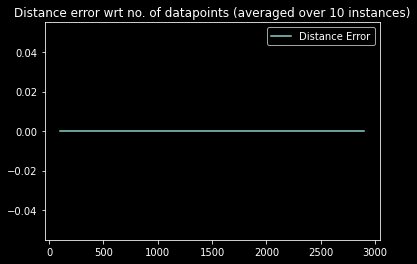

In [81]:
# check error levels wrt no. of points

import matplotlib.pyplot as plt
k=4
accuracies = []
distance_errors = []
dims = list(range(2,100))
n_s = list(range(100,3000,100))
num_cycles = 10
for n in n_s:
  data = torch.randn(size=[n,10])
  if n % 1000 == 0:
    print(n)
  m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
  distances, brute_force = torch.sort(m,dim=1)
  brute_force = brute_force[:,:k]
  distances = distances[:,:k]
  accuracy, distance_error = check_accuracy(data, brute_force, distances)
  accuracies.append((1-accuracy)*100)
  distance_errors.append(distance_error)
  
#   accuracy_mean = 0
#   distance_error_mean = 0
#   for j in range(num_cycles):
#     m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
#     distances, brute_force = torch.sort(m,dim=1)
#     brute_force = brute_force[:,1:k+1]
#     distances = distances[:,1:k+1]
#     accuracy, distance_error = check_accuracy(data, brute_force, distances)
#     accuracy_mean += accuracy
#     distance_error_mean += distance_error
#   accuracy_mean /= num_cycles
#   distance_error_mean /= num_cycles
#   accuracies.append((1-accuracy_mean)*100)
#   distance_errors.append(distance_error_mean)

plt.style.use('dark_background')
# print(distance_errors)
# plt.plot(dims,accuracies,label = 'Accuracy')
# plt.show()
# plt.plot(dims,distance_errors,label = 'Distance accuracies')
# plt.show()

plt.plot(n_s,accuracies,label = 'Error')
plt.legend()
plt.title('Accuracy error wrt no. of datapoints (averaged over 10 instances)')
plt.show()
plt.plot(n_s,distance_errors,label = 'Distance Error')
plt.legend()
plt.title('Distance error wrt no. of datapoints (averaged over 10 instances)')
plt.show()
#   print("Accuracy: ",accuracy)
#   print("Distance Error: ",distance_error,'\n')

10
20
30
40
50
60
70
80
90


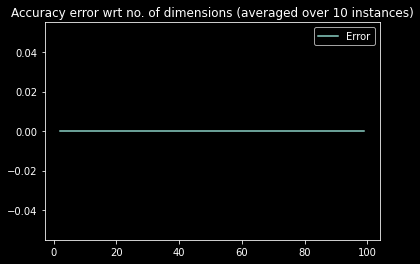

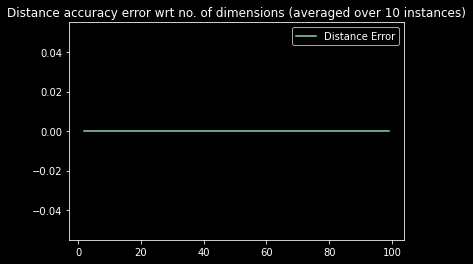

In [82]:
# check error levels wrt no. of dim

import matplotlib.pyplot as plt
k=4
accuracies = []
distance_errors = []
dims = list(range(2,100))
n_s = list(range(100,3000,100))
num_cycles = 10
# for n in n_s:
#   data = torch.randn(size=[n,10])
#   if n % 1000 == 0:
#     print(n)
for i in dims:
  data = torch.randn(size=[1000,i])
  if i % 10 == 0:
    print(i)
  m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
  distances, brute_force = torch.sort(m,dim=1)
  brute_force = brute_force[:,:k]
  distances = distances[:,:k]
  accuracy, distance_error = check_accuracy(data, brute_force, distances)
  accuracies.append((1-accuracy)*100)
  distance_errors.append(distance_error)
#   accuracy_mean = 0
#   distance_error_mean = 0
#   for j in range(num_cycles):
#     m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
#     distances, brute_force = torch.sort(m,dim=1)
#     brute_force = brute_force[:,1:k+1]
#     distances = distances[:,1:k+1]
#     accuracy, distance_error = check_accuracy(data, brute_force, distances)
#     accuracy_mean += accuracy
#     distance_error_mean += distance_error
#   accuracy_mean /= num_cycles
#   distance_error_mean /= num_cycles
#   accuracies.append((1-accuracy_mean)*100)
#   distance_errors.append(distance_error_mean)

plt.style.use('dark_background')
plt.plot(dims,accuracies,label = 'Error')
plt.title('Accuracy error wrt no. of dimensions (averaged over 10 instances)')
plt.legend()
plt.show()
plt.plot(dims,distance_errors,label = 'Distance Error')
plt.title('Distance accuracy error wrt no. of dimensions (averaged over 10 instances)')
plt.legend()
plt.show()

# plt.plot(n_s,accuracies,label = 'Error')
# plt.legend()
# plt.show()
# plt.plot(n_s,distance_errors,label = 'Distance accuracies')
# plt.legend()
# plt.show()

In [63]:
data = torch.randn(size=[1000,10])
k=4

distances2, indices = give_KNN(data,k)

m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
distances, brute_force = torch.sort(m,dim=1)

brute_force = brute_force[:,1:k+1]
distances = distances[:,1:k+1]

for i, row in enumerate(indices):
  if not torch.all(torch.eq(row,brute_force[i,:k])):
    print('Error!')
    print(distances2[i])
    print(distances[i,:2*k])
    
accuracy, distance_error = check_accuracy2(data, brute_force, distances)
print(accuracy, distance_error)

1.0 -4.4418189304451516e-07


In [75]:
data = torch.randn(size=[1000,10])
k=4

m=((data.unsqueeze(1)-data.unsqueeze(0))**2).sum(-1)#+torch.Tensor([float('inf')]).repeat(len(data)).diag() # Infinity is added to diagonal
distances, brute_force = torch.sort(m,dim=1)
brute_force = brute_force[:,1:k+1]
distances = distances[:,1:k+1]

accuracy, distance_error = check_accuracy(data, brute_force, distances)
print(accuracy)

tensor(964.)
tensor(1978.)
tensor(2958.)
tensor(4000.)
1.0
